# Neural Learning about Edges and Corners: Intro to Convolutional Neural Networks

In this chapter, we will:

- Re-use network weights in different parts of the input (called weight sharing).
- Implement the convolutional layer.

> [Geoffrey Hinton] "The Pooling Operation used in Convolutional Neural Networks is a big mistake, and the fact that is works so well is a disaster".

## Reusing Weights in multiple places

The basic premise behind "shared weights" is the following idea: "if we need to detect the same feature in multiple places, we should use the same weights".

As we know, the greatest challenge in NNs is "Overfitting". Overfitting is often caused by having more parameters than necessary to learn a specific data set. When NNs have lots of parameters and few training examples, it becomes very easy for the network to overfit. There's a better method than regularization to counter overfitting, we call it **structure**. 

Structure is when we selectively use the same group of weights in multiple purposes in a NN because we believe the same pattern needs to be detected in multiple places. This assumption is particularly true in the case of "images".  

The most famous structure in NNs is called a **convolution**, and When used in a layer, it's called a **convolutional layer**.

## The Convolutional Layer

In a convolutional layer, Lots of very small linear layers are reused in every position, instead of a single big one. The core idea behind a convolutional layer is that instead of having a big dense layer connected to the whole input, we have small but many layers with a limited number of inputs (no more than 25) & one output, that scraps the input matrices one element at a time. 

Each mini-layer is called a **convolutional kernel**, containing the weights/activation function:

<div style="text-align:center">
    <img style="width:33%;" src="static/imgs/10/convolutional_layer.png">
</div>

Shown in the above figure is an example of a **3x3 convolutional layer**. It predicts the center pixel values, moves one pixel to the right, then predicts again, and moves again, and so on. It will repeat this until it has made a prediction for every possible position in the image.

The resulting image is a 6x6 image. In CNNs, we usually use many more filters.

<div style="text-align:center">
    <img style="width:25%;" src="static/imgs/10/step_0.png">
    <img style="width:25%;" src="static/imgs/10/step_1.png">
    <img style="width:25%;" src="static/imgs/10/step_2.png">
</div>

After calculating the activation maps for each kernel, we have the option to either: 
- Sum the outputs of the kernels (element-wise, sum pooling)
- Take the element-wise mean (mean pooling)
- Take the element-wise max value (max pooling).

The last version turns out to be the most popular. The final matrix is then forward propagated to later layers.

There are a few things to notice in the above figure:
- The Top right kernel forward propagate a `1` only for horizonal lines.
- The Bottom left kernel forward propagate a `1` only for diagonal lines that point upward to the right.

It's important to realize that this technique allows each kernel to search for a certain pattern on every location of the image. The idea of setting a small set of weights to detect location-invariant patterns in large-datasets has a considerable impact on fighting overfitting and increases the networks ability to generalize well.

## A Simple Implementation in NumPy

We just need to think about mini-linear layers:

In [3]:
import numpy as np 
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

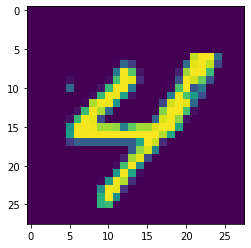

In [5]:
# Visualizing one example:
plt.imshow(X_train[89].squeeze())

In [6]:
# get example
image_example = X_train[89].squeeze() / 255.

In [7]:
def get_image_section(layer, row_from, row_to, col_from, col_to):
    return layer[row_from:row_to+1, col_from:col_to+1]

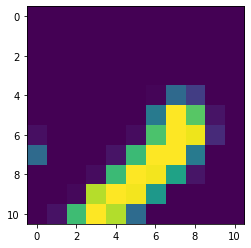

In [8]:
plt.imshow(get_image_section(image_example, 3, 13, 5, 15))

In [9]:
# book implementation.
def get_image_section(layer, row_from, row_to, col_from, col_to):
    sub_section = layer[:, row_from:row_to, col_from:col_to]
    return sub_section.reshape(-1, 1, row_to-row_from, col_to-col_from)

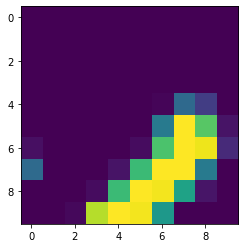

In [10]:
plt.imshow(get_image_section(image_example.reshape(1,28,28), 3, 13, 5, 15).squeeze())

We need to call this method multiple times on every location within the image. Such "for" loop can be implemented as follows:

In [11]:
images = X_train
images.shape

(60000, 28, 28)

In [12]:
batch_start, batch_end = 0, 7
layer_0 = images[batch_start:batch_end]
layer_0.shape

(7, 28, 28)

In [13]:
sections = list()
kernel_rows, kernel_cols = 3, 3
for row_start in range(layer_0.shape[1]-kernel_rows):
    for col_start in range(layer_0.shape[2]-kernel_cols):
        section = get_image_section(layer_0, row_start, row_start+kernel_rows, col_start, col_start+kernel_cols)
        sections.append(section)

In [14]:
expanded_input = np.concatenate(sections, axis=1)
expanded_input.shape

(7, 625, 3, 3)

In [15]:
es = expanded_input.shape
flattened_input = expanded_input.reshape(es[0]*es[1], -1)
flattened_input.shape

(4375, 9)

Following the above implementation, `layer_0` will be a batch of 28x28 images. The `for` loop slides over every subregion in the images, extract and append it to a list called `sections`. `sections` is then concatenated and reshaped in a peculiar way. We Pretend for now that each individual subregion is its own image.

Forward-propagating the subregions through a linear layer with one output neuron is the same as predicting that linear layer over every sub-region in every batch. The following shows the entire NumPy implementation: 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sys import exit
np.random.seed(1)

In [29]:
from tensorflow.keras.datasets import mnist

In [30]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [31]:
images, labels = (x_train[:1000].reshape(1000, 28*28) / 255, y_train[:1000])
images.shape, labels.shape

((1000, 784), (1000,))

In [32]:
one_hot_labels = np.zeros(shape=(labels.shape[0], 10))
for i, v in enumerate(labels):
    one_hot_labels[i][v] = 1
labels = one_hot_labels

In [33]:
test_images = x_test.reshape(x_test.shape[0], 28*28) / 255
test_labels = np.zeros(shape=(y_test.shape[0], 10))
for i, v in enumerate(y_test):
    test_labels[i][v] = 1

In [34]:
# activation functions
def tanh(x):
    return np.tanh(x)

def grad_tanh(y):
    return 1 - y**2

def softmax(x):
    exps = np.exp(x)
    return exps/np.sum(exps, axis=1, keepdims=True)

In [35]:
lr, epochs = (2, 300)
pixels_per_image, num_labels = (784, 10)
batch_size = 128

input_rows, input_cols = (28, 28)
kernel_rows, kernel_cols = (3, 3)
num_kernels = 4

In [36]:
# `Hidden` is of that size because we are training a 1-D Convolutional Layer, not a 2D, and so it's taking more spaces
hidden_size = ((input_rows - kernel_rows + 1) * (input_cols - kernel_cols + 1)) * num_kernels

In [37]:
kernels = (0.02 * np.random.random((kernel_rows*kernel_cols, num_kernels))) - 0.01
weights_1_2 = (0.2 * np.random.random((hidden_size, num_labels))) - 0.1

kernels.shape, weights_1_2.shape

((9, 4), (2704, 10))

In [38]:
def get_image_section(layer, row_from, row_to, col_from, col_to):
    sub_section = layer[:, row_from:row_to, col_from:col_to]
    return sub_section.reshape(-1, 1, row_to-row_from, col_to-col_from)

In [ ]:
# Training Loop
for epoch in range(epochs):  # for each epoch
    correct_count = 0
    for batch in range(int(len(images) / batch_size)):  # for each batch
        batch_start, batch_end = (batch*batch_size), ((batch+1)*batch_size)
        
        # get input
        layer_0 = images[batch_start:batch_end]
        layer_0 = layer_0.reshape(layer_0.shape[0], 28, 28)
        
        # extract all sections from all batch images
        sections = list()
        for row_start in range(layer_0.shape[1] - kernel_rows + 1):  # +1 by akramz.
            for col_start in range(layer_0.shape[2]-kernel_cols+1):
                section = get_image_section(layer_0, row_start, row_start+kernel_rows, col_start, col_start+kernel_cols)
                sections.append(section)
        # [0] 128 batch elements, [1] 676 sections/image, 3x3 section size 
        expanded_input = np.concatenate(sections, axis=1)
        
        es = expanded_input.shape
        # shape: (128x676, 3x3)
        flattened_input = expanded_input.reshape(es[0] * es[1], -1)
        
        # forward propagation
        kernel_output = flattened_input.dot(kernels)  # 16 kernels
        layer_1 = tanh(kernel_output.reshape(es[0], -1))
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask*2
        layer_2 = softmax(np.dot(layer_1, weights_1_2))
        
        # count corrects
        for k in range(batch_size):
            labelset = labels[batch_start+k:batch_start+k+1]
            _inc = int(np.argmax(layer_2[k:k+1]) == np.argmax(labelset))
            correct_count += _inc
        
        # back propagation
        layer_2_delta = (labels[batch_start:batch_end]-layer_2)/(batch_size*layer_2.shape[0])
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * grad_tanh(layer_1)
        layer_1_delta *= dropout_mask
        weights_1_2 += lr * layer_1.T.dot(layer_2_delta)
        l1d_reshape = layer_1_delta.reshape(kernel_output.shape)
        k_udpate = flattened_input.T.dot(l1d_reshape)
        kernels -= lr * k_udpate
        
        # test
        test_correct_count = 0
        for i in range(len(test_images)):
            layer_0 = test_images[i:i+1]
            layer_0 = layer_0.reshape(layer_0.shape[0], 28, 28)
            sections = list()
            for row_start in range(layer_0.shape[1]-kernel_rows+1):
                for col_start in range(layer_0.shape[2]-kernel_cols+1):
                    section = get_image_section(layer_0, row_start, row_start+kernel_rows, col_start, col_start+kernel_cols)
                    sections.append(section)
            expanded_input = np.concatenate(sections, axis=1)
            es = expanded_input.shape
            flattened_input = expanded_input.reshape(es[0]*es[1],-1)
            kernel_output = flattened_input.dot(kernels) 
            layer_1 = tanh(kernel_output.reshape(es[0],-1)) 
            layer_2 = np.dot(layer_1,weights_1_2)
            test_correct_count += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))
        
    if(epoch % 1 == 0):
        print(f"I: {epoch} | Test-Acc: {round(test_correct_count / float(len(test_images)), 5)} | Train-Acc: {round(correct_count/float(len(images)), 5)}")

As we can see, swapping the first layer with a convolutional layer gives another few percentage points in error reduction. The output of the convolutional layer is itself also a series of two-dimensional images. 

Most uses of convolutional layers stack multiple layers on top of each other such that each layer treats the previous output as its input. Stacked Convolutional Layers are one of the main developments that allowed for very deep neural networks and, by extension, the popularization of the phrase "deep learning".

It can't be overstressed that this invension was a landmark moment for the field; without it, we might still be living the previous AI Winter even as of now.s

## Summary
### Reusing weights is one of the most important innovations in deep learning

The notion of reusing weights to increase accuracy is hugely important and has an intuitive basis. Let's consider what we would need to detect that a cat is in an image:
1. Colors.
2. lines and edges.
3. Corners & small shapes.
4. finally the combination of such low-level features that corresponds to a cat.

Notice that such primitive building blocks exist all over the image pixels. The intelligence for detecting lines and edges is learned in the neural network's weights, but if we use different weights to analyze different parts of an image, each section of the weights has to learn what a line is, which is not efficient and can quickly lead to overfitting.

When a Neural Network needs to use the same idea in multiple places, try to use the same weights in multiple places. This will make the weights more intelligent by giving them more samples (sections) to learn from, increasing generalization.

Many of the biggest developments in deep learning over the past five years are iterations of this idea: CNNs, RNNs, Word Embeddings, & the recently published capsule networks can all be viewed through this lens. 

In summary, When we have the same features to be learned in multiple places, we should force the network to use the same weights in those places.

---